# El Nino Identification

In [1]:
import pandas as pd 
import xarray as xr 

# Load the data
ds = xr.open_mfdataset([r"ssta.2011_2024.nc"], chunks="auto").sortby('time').sel(time=slice('2014-01', '2024-12'))
elnino_events = pd.read_csv('elnino_events.csv')

ssta = ds['anom'].sel(lat=slice(-5, 5))

Event: 2014 | Start: 2014 | End: 2015
Event: 2015 | Start: 2015 | End: 2016
Event: 2018 | Start: 2018 | End: 2019
Event: 2023 | Start: 2023 | End: 2024


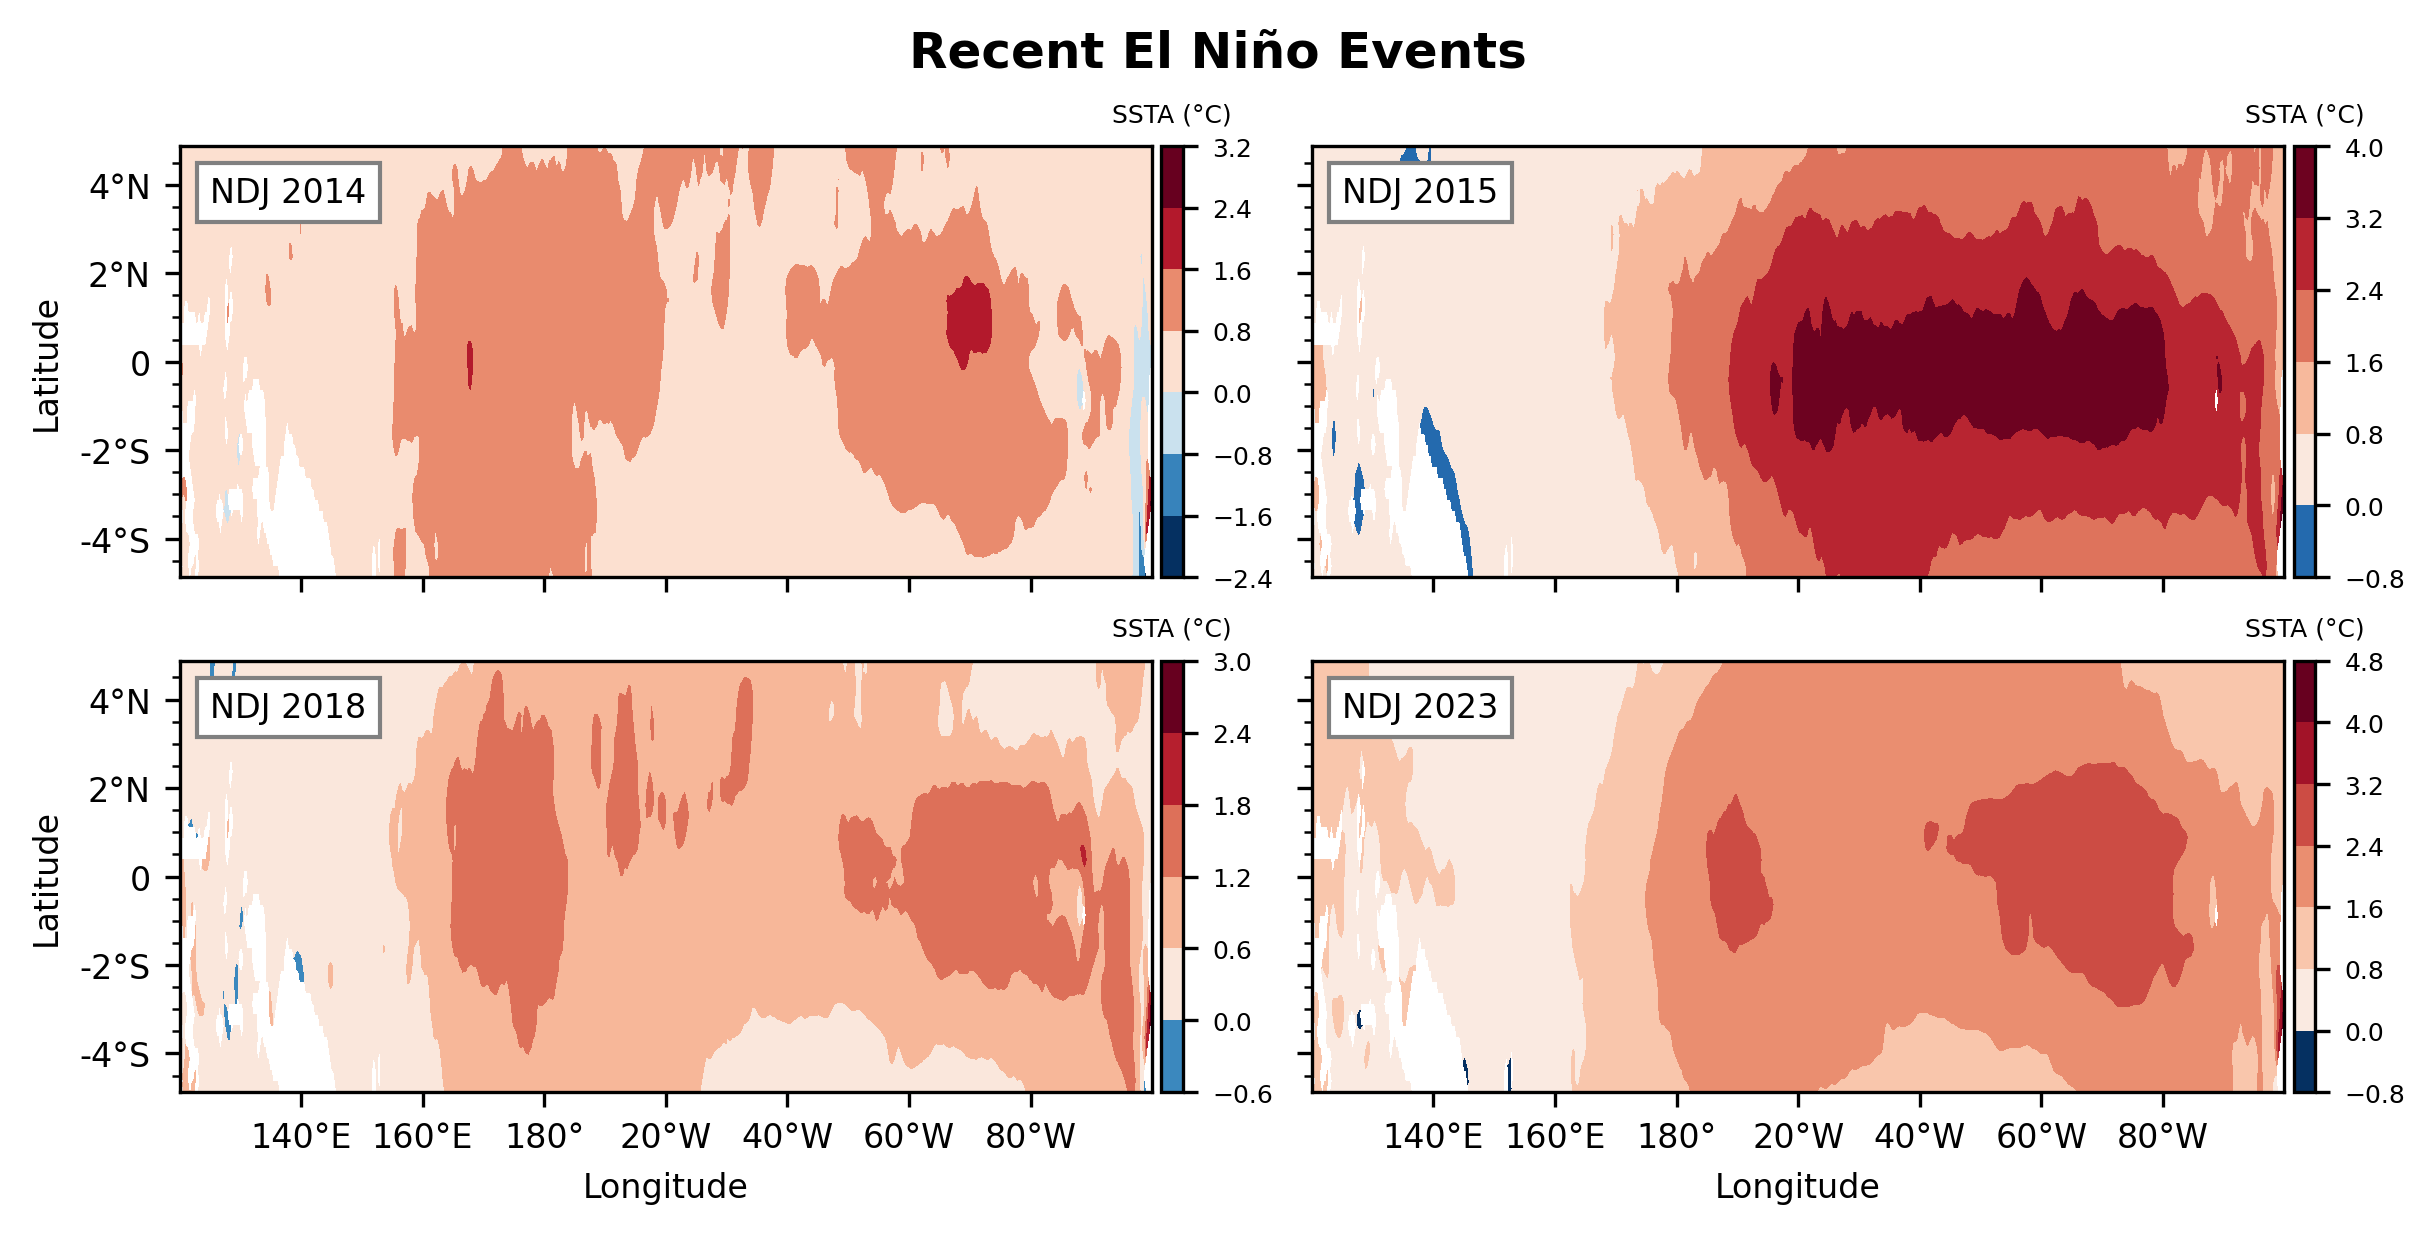

In [ ]:
import matplotlib.pyplot as plt 
import numpy as np
import matplotlib.ticker as ticker
from scipy.signal import find_peaks
from matplotlib.offsetbox import AnchoredText
from matplotlib.colors import TwoSlopeNorm
from matplotlib.ticker import FuncFormatter
import pandas as pd 
import xarray as xr 


ndata = elnino_events.shape[0]
ncols = 2
nrows = int(ndata/ncols)

peaks = []
signals = []

# axes format
lat_format = lambda v, _: f'{v:.0f}°N' if v > 0 else (f'{v:.0f}°S' if v < 0 else '0')
def lon_format(v, _):
    # v is longitude in degrees east (0-360)
    if v > 180:
        return f'{360 - v:.0f}°W'
    elif v < 180:
        return f'{v:.0f}°E'
    else:
        return '180°'

fig, axs = plt.subplots(figsize=(8, 4), nrows=nrows, ncols=ncols, constrained_layout=True, sharex=True, sharey=True, dpi=300)
axs = axs.flatten()
fig.suptitle('Recent El Niño Events', fontweight='bold')


for idx, row in elnino_events.iterrows():

    start = row['Start'][:4]
    end   = row['End'][:4]
    event = row['Year']
    print(f'Event: {event} | Start: {start} | End: {end}')

    
    elnino_period = slice(f'{start}-11', f'{end}-01')
    subset = data.sel(time=elnino_period).mean(['time'])

    signal = subset.mean('lat').values
    signals.append(signal)
    peak, _ = find_peaks(signal, height=np.mean(signal))
    peaks.append(peak)

    # normalization
    finite_vals = subset.fillna(0).values
    vmin, vmax = finite_vals.min(), finite_vals.max()
    if vmin == 0:
        vmin = -0.2
    if vmax == 0:
        vmax = 0.2

    norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
    
    c = axs[idx].contourf(subset.lon, subset.lat, subset.values, levels=5, cmap='RdBu_r', norm=norm)
    cbar = fig.colorbar(c, ax=axs[idx], pad=0.01, aspect=20)
    cbar.ax.set_title('SSTA (°C)', fontsize=6, ha='center', loc='center')
    cbar.ax.tick_params(labelsize=6)

    # add text
    at = AnchoredText(f"NDJ {event}", prop=dict(size=8), frameon=True, loc='upper left')
    at.patch.set_edgecolor("grey")
    axs[idx].add_artist(at)
    axs[idx].tick_params(axis='both', which='major', labelsize=8)
    if idx in [2, 3]:
        axs[idx].set_xlabel('Longitude', fontsize=8)
    if idx in [0, 2]:
        axs[idx].set_ylabel('Latitude', fontsize=8)
    axs[idx].xaxis.set_major_formatter(FuncFormatter(lon_format))
    axs[idx].yaxis.set_major_formatter(FuncFormatter(lat_format))
    axs[idx].yaxis.set_minor_locator(ticker.AutoMinorLocator())

plt.show()
#fig.savefig('ElNinos.2014_2024.png', dpi=300, bbox_inches='tight')

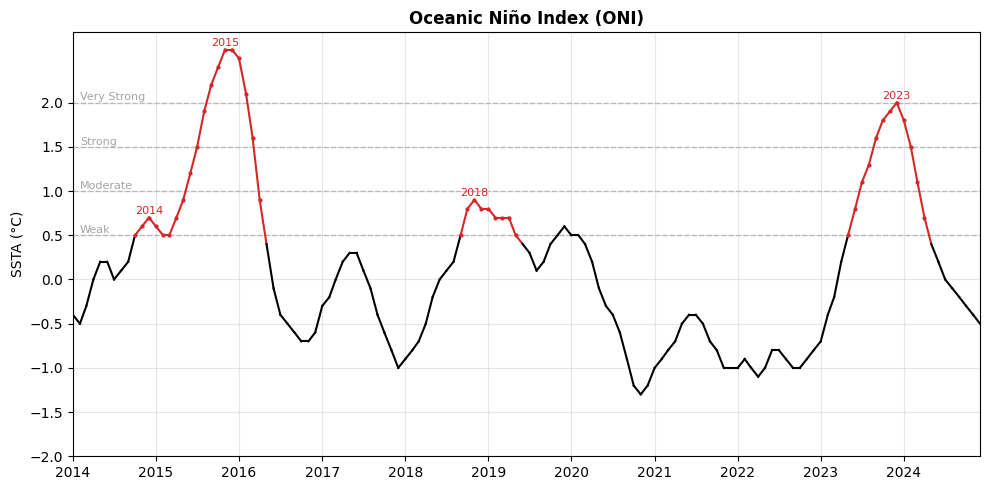

Consecutive sequences detected:
El Niño periods (≥0.5°C for 3+ months): 40 data points
La Niña periods (≤-0.5°C for 3+ months): 32 data points

El Niño Events Detected: 2014 2015 2018 2023 

In [2]:
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np  
from scipy.signal import find_peaks

# --- Data Preparation ---
# Load the dataset
ds = pd.read_csv(r'C:\Users\binta\Python\Thesis\ONI\ONI_CPC.txt', sep=',')

# Drop unused columns
ds = ds.drop(columns=['O'])

# Add a new column for month indices
season_to_month_index = {
    'DJF': 1, 'JFM': 2, 'FMA': 3, 'MAM': 4, 'AMJ': 5, 'MJJ': 6,
    'JJA': 7, 'JAS': 8, 'ASO': 9, 'SON': 10, 'OND': 11, 'NDJ': 12
}
ds['Month'] = ds['SEAS'].map(season_to_month_index)

# Add a new column for formatted date (Year-Month)
ds['Year-Month'] = np.array([f"{year}-{month:02d}" for year, month in zip(ds['YR'], ds['Month'])], dtype='datetime64[M]')

# Subset the data for the years 2000 to 2024
start_year = 2014
data = ds[(ds['YR'] >= start_year) & (ds['YR'] <= 2024)]
date = data['Year-Month'].values
oni = np.round(data['ANOM'].values, 1)

# --- El Niño Detection --- 
# Function to find consecutives ONI values
def find_consecutive_sequences(condition_array, min_length=3):
    """
    Find consecutive sequences where condition is True for at least min_length points
    Returns boolean array indicating which points are part of consecutive sequences
    """
    result = np.zeros_like(condition_array, dtype=bool)
    
    # Find start and end points of consecutive True sequences
    padded = np.concatenate(([False], condition_array, [False]))
    diff = np.diff(padded.astype(int))
    starts = np.where(diff == 1)[0]
    ends = np.where(diff == -1)[0]
    
    # Mark sequences that are long enough
    for start, end in zip(starts, ends):
        if end - start >= min_length:
            result[start:end] = True
    
    return result

# Find consecutive above/below threshold (min 3 in a row)
above = oni >= 0.5   # El Niño
below = oni < -0.5  # La Niña
consecutive_above = find_consecutive_sequences(above, min_length=5)
consecutive_below = find_consecutive_sequences(below, min_length=5)

# Initialize the figure
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the time series with different colors for consecutive sequences
for i in range(len(oni) - 1):
    if consecutive_above[i]:
        color = 'tab:red'
    # elif consecutive_below[i]:
    #     color = 'tab:blue'
    else:
        color = 'black'
    ax.plot(date[i:i+2], oni[i:i+2], color=color, linewidth=1.5)

# Overlay consecutive sequences
for i in range(len(oni)):
    if consecutive_above[i]:
        ax.plot(date[i:i+1], oni[i:i+1], 'o', color='tab:red', markersize=2)
    # elif consecutive_below[i]:
    #     ax.plot(date[i:i+1], oni[i:i+1], 'o', color='tab:blue', markersize=2)

# Define El Niño intensity categories
categories = {
    0.5: 'Weak',
    1: 'Moderate', 
    1.5: 'Strong',
    2: 'Very Strong'
}

# Add horizontal lines for El Niño intensity categories
for threshold, label in categories.items():
    ax.axhline(y=threshold, color='tab:grey', linestyle='--', linewidth=1, alpha=0.5, zorder=0)
    ax.text(x=date[1], y=threshold+0.025, s=label, color='tab:grey', alpha=0.7, zorder=0, fontsize=8)

# Add legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='tab:red', lw=2, label='El Niño (≥0.5°C for 3+ months)'),
    Line2D([0], [0], color='tab:blue', lw=2, label='La Niña (≤-0.5°C for 3+ months)'),
    Line2D([0], [0], color='black', lw=1, label='Normal conditions')
]
#ax.legend(handles=legend_elements, loc='upper right', fontsize=8)

# Set labels and title
ax.set_ylabel('SSTA (°C)')
ax.set_title('Oceanic Niño Index (ONI)', fontweight='bold')
ax.set_yticks([-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2])
ax.set_xlim(left=date.min(), right=date.max())

# Find 
peaks, _ = find_peaks(oni, height=0.5)
plotted_years = set()
for idx in np.unique(peaks):
    year = int(str(date[idx])[:4])
    if consecutive_above[idx] and year not in plotted_years:
        ax.text(date[idx], oni[idx] + 0.02, str(year),
                color='tab:red', fontsize=8, ha='center', va='bottom')
        plotted_years.add(year)
fig.canvas.draw_idle()


# Adjust layout and display the plot
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print some statistics about detected events
print("Consecutive sequences detected:")
print(f"El Niño periods (≥0.5°C for 3+ months): {np.sum(consecutive_above)} data points")
print(f"La Niña periods (≤-0.5°C for 3+ months): {np.sum(consecutive_below)} data points")


elninos_years = np.unique(date[peaks][consecutive_above[peaks]].astype('datetime64[Y]').astype(int) + 1970)
print("\nEl Niño Events Detected:", end=' ')
for y in elninos_years: print(f"{y}", end=' ')

# Option to save the figure
savefig = False  # Set to True if you want to save the figure
if savefig:
    fig.savefig(fr'C:\Users\binta\Python\Thesis\SeaSurfaceTemperature\ONI.{start_year}_2024.png', dpi=300, bbox_inches='tight')

Event: 2014 | Start: 2014 | End: 2015
Event: 2015 | Start: 2015 | End: 2016
Event: 2018 | Start: 2018 | End: 2019
Event: 2023 | Start: 2023 | End: 2024


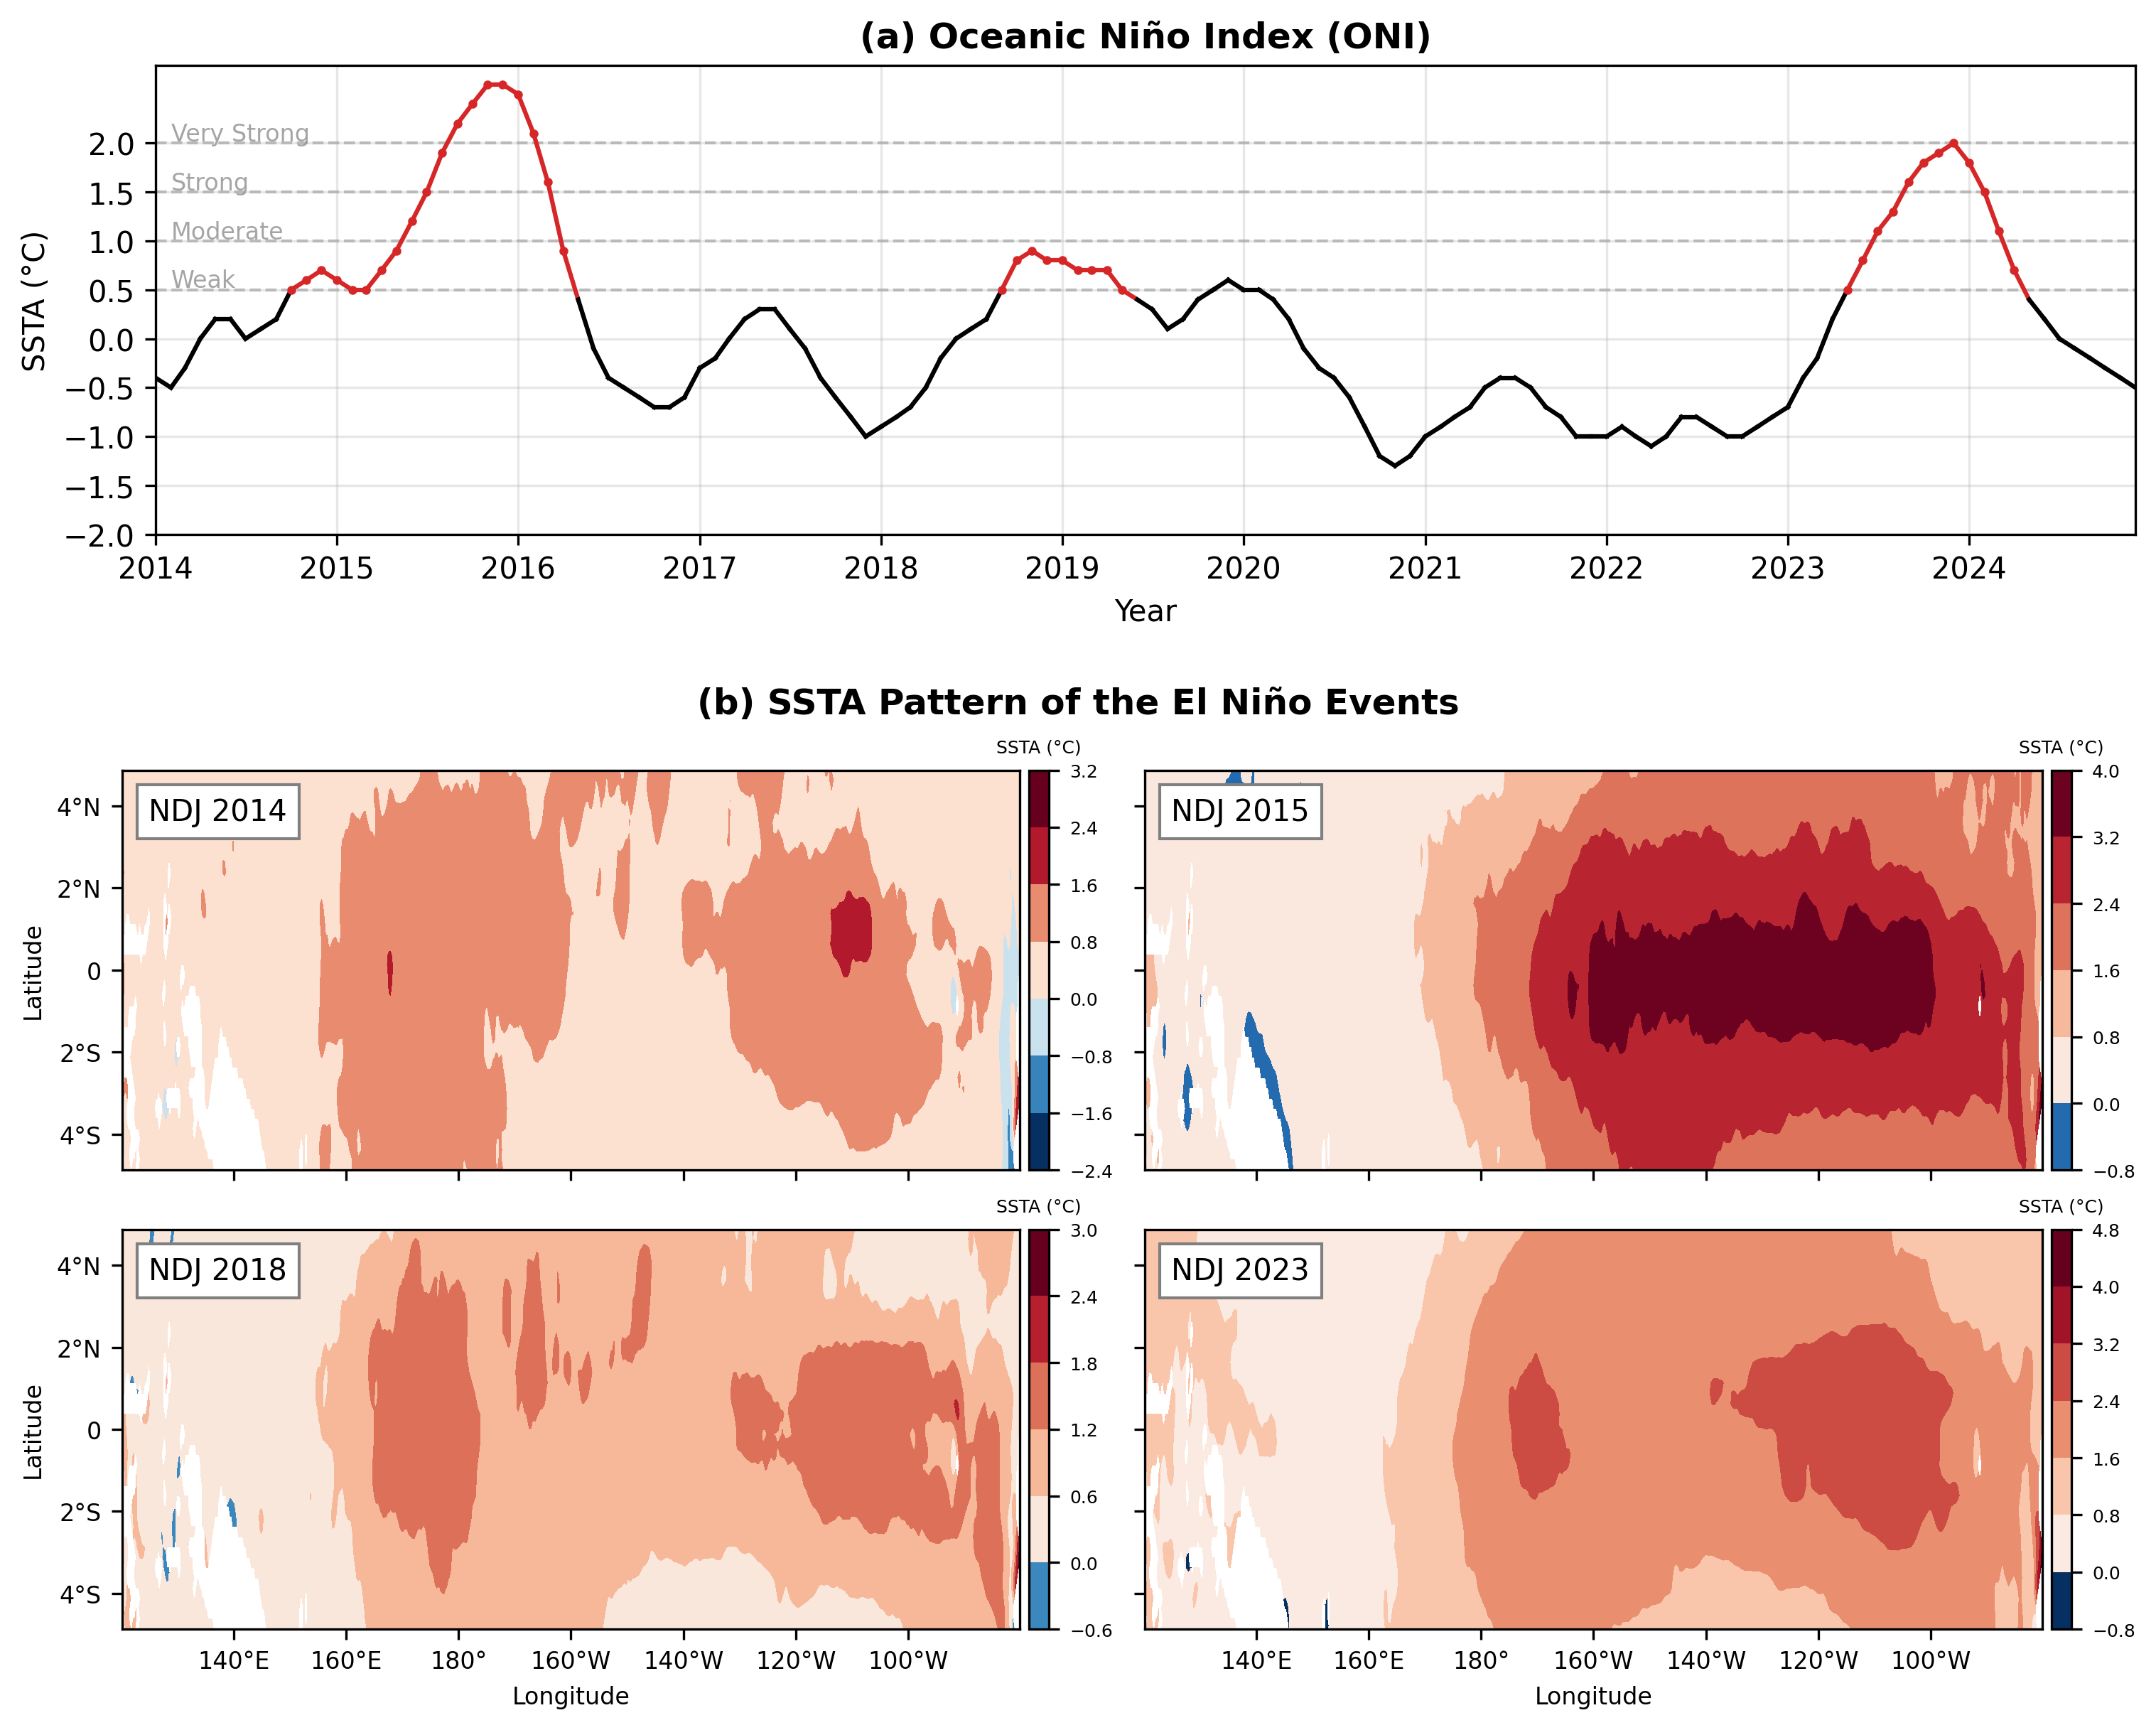

In [4]:
import matplotlib.pyplot as plt 
import numpy as np
import matplotlib.ticker as ticker
from scipy.signal import find_peaks
from matplotlib.offsetbox import AnchoredText
from matplotlib.colors import TwoSlopeNorm
from matplotlib.ticker import FuncFormatter
import pandas as pd 
import xarray as xr 


ndata = elnino_events.shape[0]
ncols = 2
nrows = int(ndata/ncols)

peaks = []
signals = []

# axes format
lat_format = lambda v, _: f'{v:.0f}°N' if v > 0 else (f'{abs(v):.0f}°S' if v < 0 else '0')
def lon_format(v, _):
    # v is longitude in degrees east (0-360)
    if v > 180:
        return f'{360 - v:.0f}°W'
    elif v < 180:
        return f'{v:.0f}°E'
    else:
        return '180°'

fig = plt.figure(layout='constrained', figsize=(10, 8), dpi=300)
subfigs = fig.subfigures(2, 1, hspace=0.05, height_ratios=[3, 5])

axstop = subfigs[0].subplots(1)
axsbot = subfigs[1].subplots(2, 2, sharex=True, sharey=True)

# --- Top Plot: ONI
for i in range(len(oni) - 1):
    if consecutive_above[i]:
        color = 'tab:red'
    # elif consecutive_below[i]:
    #     color = 'tab:blue'
    else:
        color = 'black'
    axstop.plot(date[i:i+2], oni[i:i+2], color=color, linewidth=1.5)

# Overlay consecutive sequences
for i in range(len(oni)):
    if consecutive_above[i]:
        axstop.plot(date[i:i+1], oni[i:i+1], 'o', color='tab:red', markersize=2)


# Define El Niño intensity categories
categories = {
    0.5: 'Weak',
    1: 'Moderate', 
    1.5: 'Strong',
    2: 'Very Strong'
}

# Add horizontal lines for El Niño intensity categories
for threshold, label in categories.items():
    axstop.axhline(y=threshold, color='tab:grey', linestyle='--', linewidth=1, alpha=0.5, zorder=0)
    axstop.text(x=date[1], y=threshold+0.025, s=label, color='tab:grey', alpha=0.7, zorder=0, fontsize=8)

# Add legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='tab:red', lw=2, label='El Niño (≥0.5°C for 3+ months)'),
    Line2D([0], [0], color='tab:blue', lw=2, label='La Niña (≤-0.5°C for 3+ months)'),
    Line2D([0], [0], color='black', lw=1, label='Normal conditions')
]
#ax.legend(handles=legend_elements, loc='upper right', fontsize=8)

# Set labels and title
axstop.set_ylabel('SSTA (°C)')
axstop.set_title('(a) Oceanic Niño Index (ONI)', fontweight='bold')
axstop.set_yticks([-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2])
axstop.set_xlim(left=date.min(), right=date.max())
axstop.set_xlabel('Year')

axstop.grid(True, alpha=0.3)

# --- Bottom Plot: SSTA
axsbot = axsbot.flatten()

subfigs[1].suptitle('(b) SSTA Pattern of the El Niño Events', fontweight='bold')

for idx, row in elnino_events.iterrows():

    start = row['Start'][:4]
    end   = row['End'][:4]
    event = row['Year']
    print(f'Event: {event} | Start: {start} | End: {end}')

    elnino_period = slice(f'{start}-11', f'{end}-01')
    subset = ssta.sel(time=elnino_period).mean(['time'])

    signal = subset.mean('lat').values
    signals.append(signal)
    peak, _ = find_peaks(signal, height=np.mean(signal))
    peaks.append(peak)

    # normalization
    finite_vals = subset.fillna(0).values
    vmin, vmax = finite_vals.min(), finite_vals.max()
    if vmin == 0:
        vmin = -0.2
    if vmax == 0:
        vmax = 0.2

    norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
    
    c = axsbot[idx].contourf(subset.lon, subset.lat, subset.values, levels=5, cmap='RdBu_r', norm=norm)
    cbar = fig.colorbar(c, ax=axsbot[idx], pad=0.01, aspect=20)
    cbar.ax.set_title('SSTA (°C)', fontsize=6, ha='center', loc='center')
    cbar.ax.tick_params(labelsize=6)

    # add text
    at = AnchoredText(f"NDJ {event}", prop=dict(size=10), frameon=True, loc='upper left')
    at.patch.set_edgecolor("grey")
    axsbot[idx].add_artist(at)
    axsbot[idx].tick_params(axis='both', which='major', labelsize=8)
    if idx in [2, 3]:
        axsbot[idx].set_xlabel('Longitude', fontsize=8)
    if idx in [0, 2]:
        axsbot[idx].set_ylabel('Latitude', fontsize=8)
    axsbot[idx].xaxis.set_major_formatter(FuncFormatter(lon_format))
    axsbot[idx].yaxis.set_major_formatter(FuncFormatter(lat_format))

plt.show()
fig.savefig('ElNino.Identification.png', dpi=500, bbox_inches='tight')

# Hovmoller

In [1]:
import pandas as pd 
import xarray as xr 

# Load the data
ds = xr.open_mfdataset([r"ssta.2011_2024.nc"], chunks="auto").sortby('time').sel(time=slice('2014-01', '2024-12'))
elnino_events = pd.read_csv('elnino_events.csv')

ssta = ds['anom'].sel(lat=slice(-5, 5))

In [2]:
time = ssta['time'].sel(time=slice('2023-01', '2024-12'))

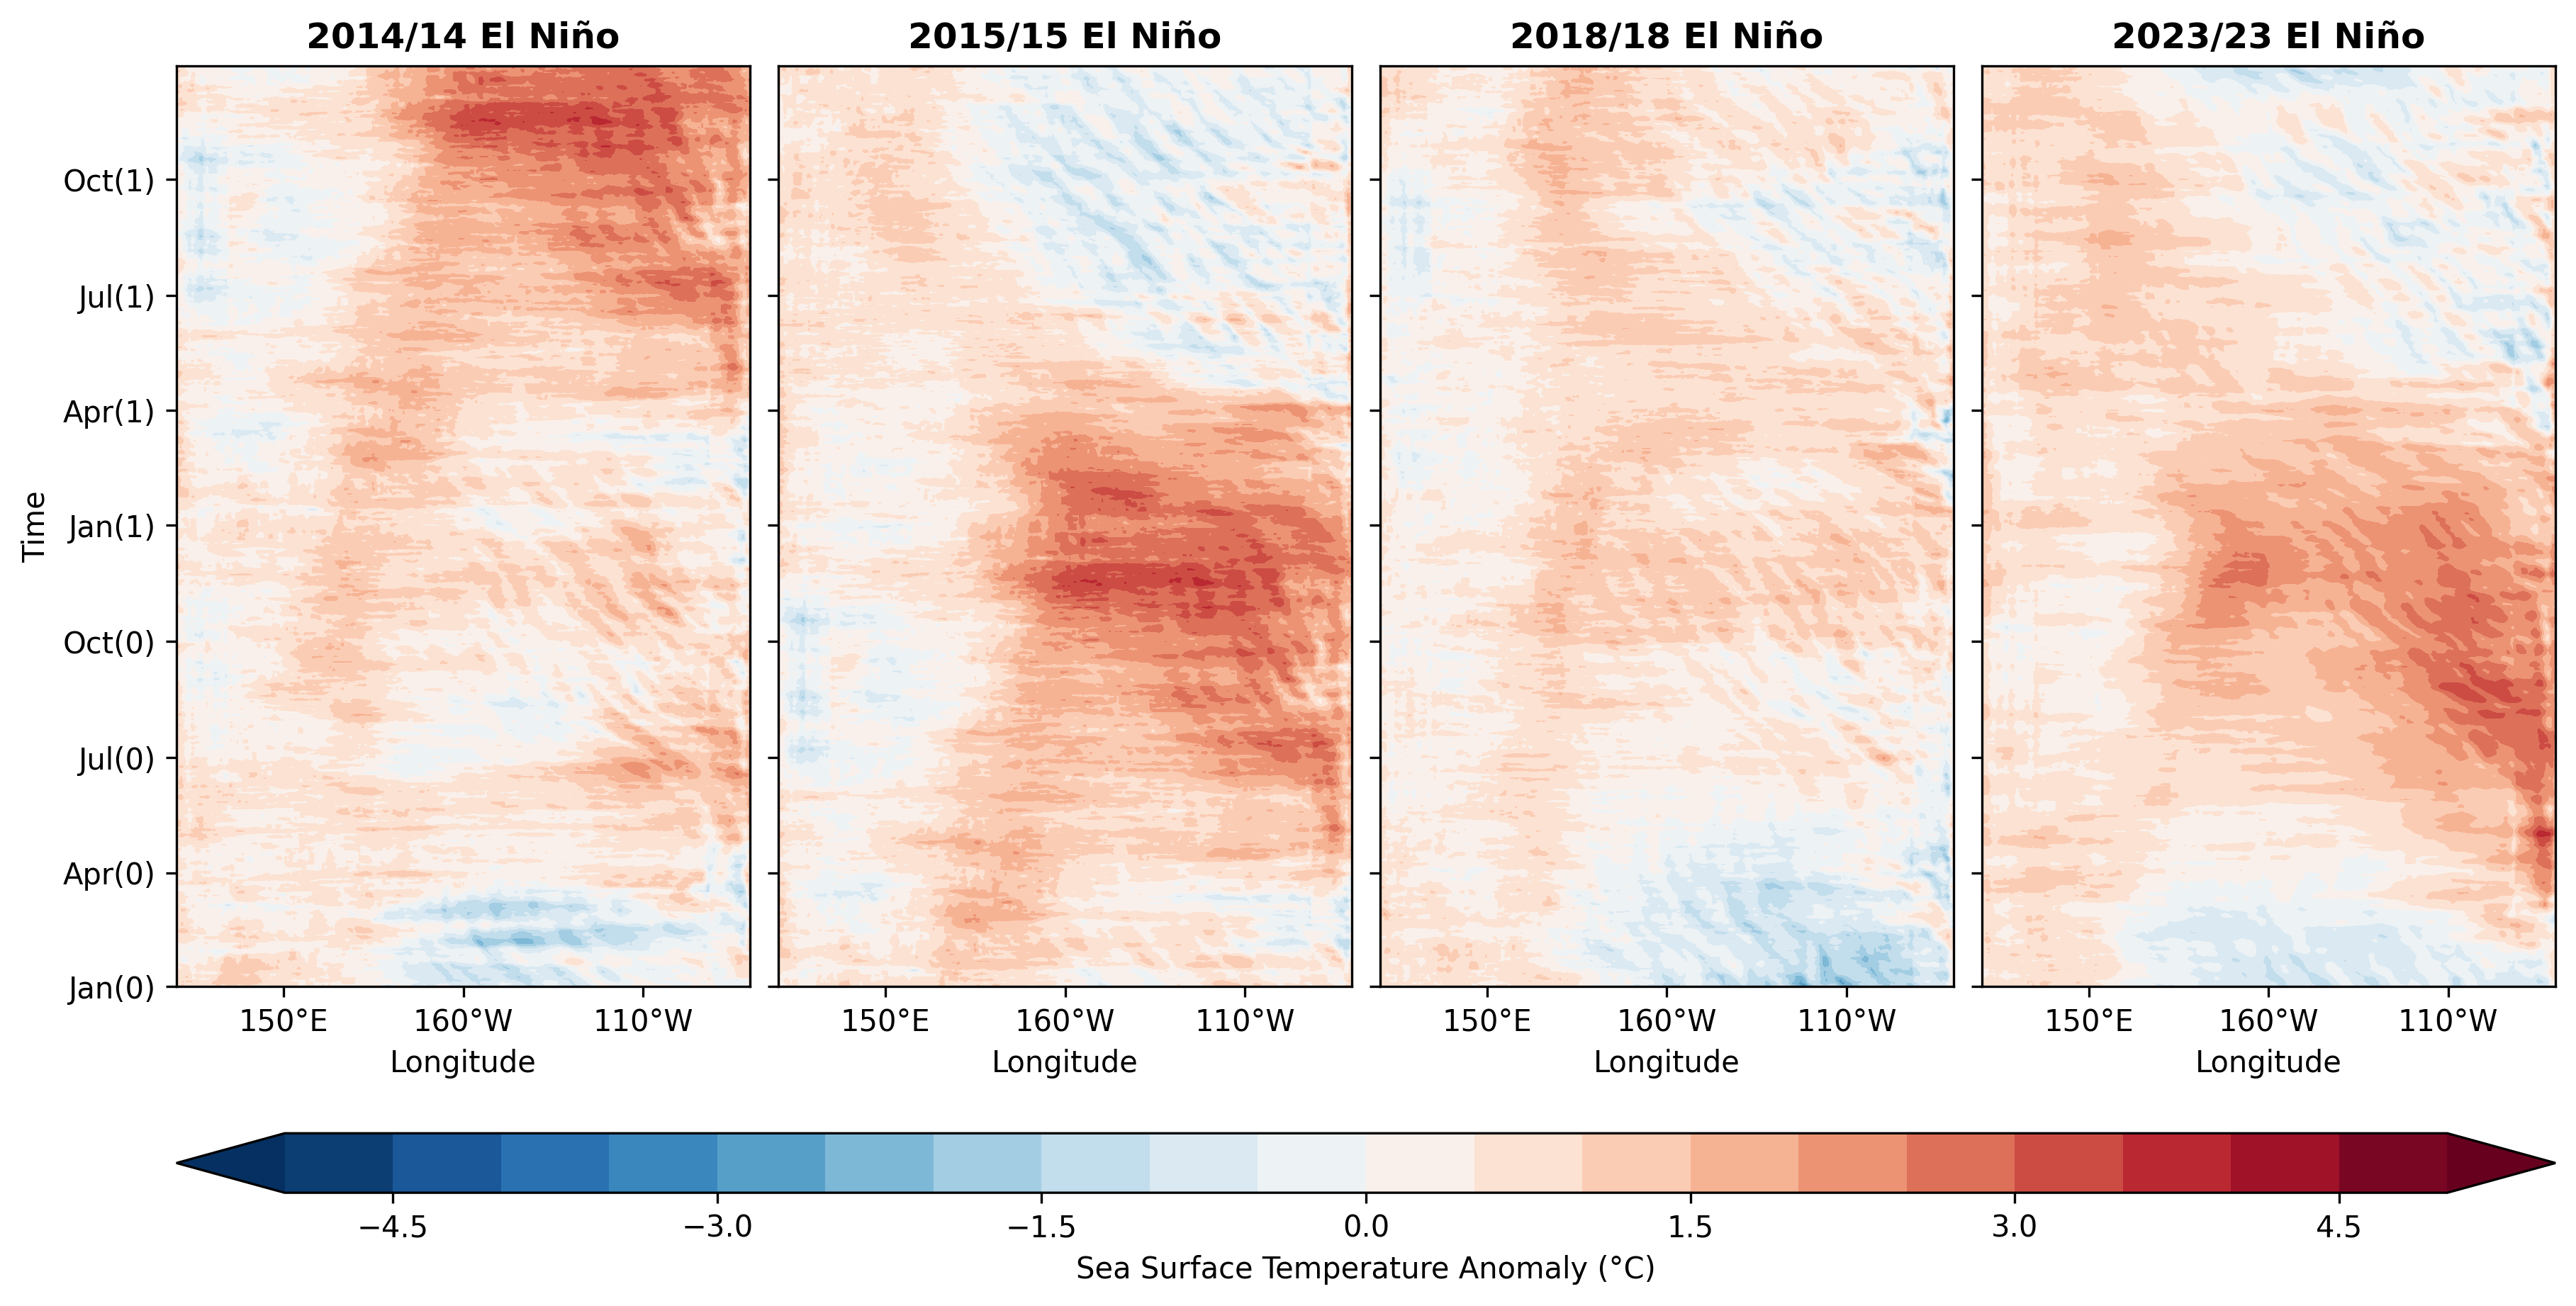

In [16]:
import matplotlib.pyplot as plt 
import numpy as np
import matplotlib.ticker as ticker
from scipy.signal import find_peaks
from matplotlib.offsetbox import AnchoredText
from matplotlib.colors import TwoSlopeNorm
from matplotlib.ticker import FuncFormatter
import pandas as pd 
import xarray as xr 

# Convert dummy_time to pandas DatetimeIndex for easier handling
dt_index = pd.to_datetime(time)

# Find the first index of each month
month_start_locs = dt_index.to_series().groupby([dt_index.year, dt_index.month]).head(1).index
month_start_labels = [f"{d.strftime('%b')}({d.year - 2023})" for d in month_start_locs]
tstep = 3

# axes format
lat_format = lambda v, _: f'{v:.0f}°N' if v > 0 else (f'{v:.0f}°S' if v < 0 else '0')
lon_format = lambda v, _: f'{360 - v:.0f}°W' if v > 180 else (f'{v:.0f}°E' if v < 180 else '180°')

fig, ax = plt.subplots(figsize=(12, 6), nrows=1, ncols=4, constrained_layout=True, sharey=True, dpi=300)

norm = TwoSlopeNorm(vmin=-5, vcenter=0, vmax=5)
levels = np.linspace(-5, 5, 21)

for idx, row in elnino_events.iterrows():
    start = row['Start'][:4]
    end   = row['End'][:4]
    event = row['Year']
    
    avg  = ssta.sel(time=slice(f'{start}-01', f'{end}-12')).mean(['lat'])

    c = ax[idx].contourf(avg.lon, time[:730], avg.values[:730], cmap='RdBu_r', levels=levels, norm=norm, extend='both')

    ax[idx].set_title(f"{event}/{str(event)[2:]} El Niño", fontweight='bold')
    ax[idx].set_xlabel('Longitude')
    ax[idx].xaxis.set_major_formatter(FuncFormatter(lon_format))

ax[0].set_yticks(month_start_locs[::tstep])
ax[0].set_yticklabels(month_start_labels[::tstep])
ax[0].set_ylabel('Time')
cbar = fig.colorbar(c, ax=ax, pad=0.05, aspect=40, orientation='horizontal', label='Sea Surface Temperature Anomaly (°C)')
plt.show()
fig.savefig("SSTA.Hovmoller.png", dpi=300, bbox_inches='tight')